# 02. Разведочный анализ данных (EDA)
**Цель**: Исследовать паттерны продаж и зависимости между признаками.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from config.settings import DATA_PATH, REPORTS_PATH

# Настройки
plt.style.use("seaborn-v0_8-whitegrid")
sns.set_palette("husl")

In [2]:
# 1. Загрузка и очищение данных
print("Загрузка очищенных данных...")
df = pd.read_csv(DATA_PATH / "processed/cleaned_data.csv", parse_dates=["Date"])
print(f"Загружено записей: {len(df):,}")
print(f"Диапазон дат: {df["Date"].min().date()} - {df["Date"].max().date()}")

Загрузка очищенных данных...
Загружено записей: 785,695
Диапазон дат: 2013-01-01 - 2015-05-30



Анализ по дням недели:
                  mean          std   count
DayOfWeek                                  
1          8191.145314  3695.843181  127531
2          7055.997670  3054.406683  133929
3          6706.434908  2777.939822  131897
4          6764.121842  2773.258575  125285
5          7066.970251  2763.590881  128609
6          5887.280951  2866.134038  135141
7          8203.940963  6218.541447    3303


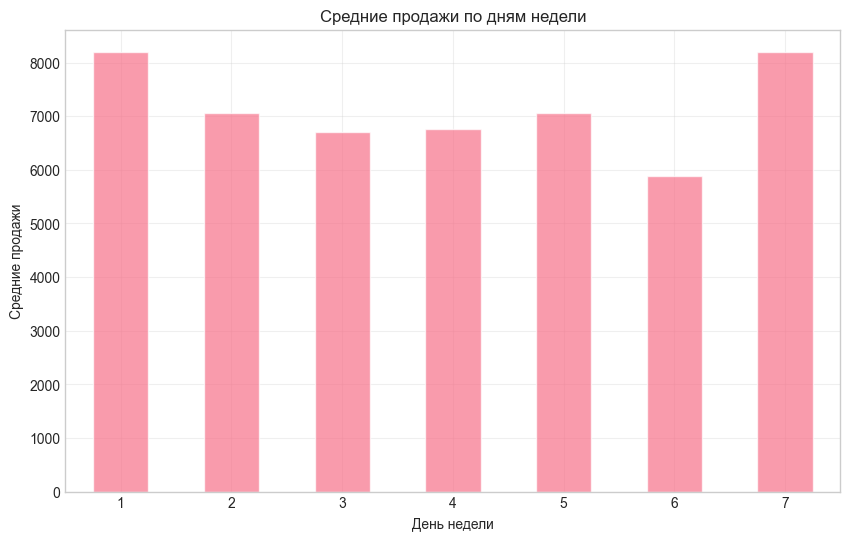

In [3]:
# 2. Анализ продаж по дням недели
print("\nАнализ по дням недели:")
sales_by_day = df.groupby("DayOfWeek")["Sales"].agg(["mean", "std", "count"])
print(sales_by_day)

plt.figure(figsize=(10, 6))
sales_by_day["mean"].plot(kind="bar", alpha=0.7)
plt.title("Средние продажи по дням недели")
plt.xlabel("День недели")
plt.ylabel("Средние продажи")
plt.xticks(rotation=0)
plt.grid(True, alpha=0.3)
plt.savefig(REPORTS_PATH / "sales_by_day.png", dpi=300, bbox_inches="tight")
plt.show()

In [4]:
# 3. Влияние промо-акций
print("\nВлияние промо-акций:")
promo_effect = df.groupby("Promo")["Sales"].agg(["mean", "count"])
promo_effect["diff_percent"] = ((promo_effect.loc[1, "mean"] / promo_effect.loc[0, "mean"]) - 1) * 100
print(promo_effect)


Влияние промо-акций:
              mean   count  diff_percent
Promo                                   
0      5929.151238  435982      38.32703
1      8201.618839  349713      38.32703



Сезонность продаж:


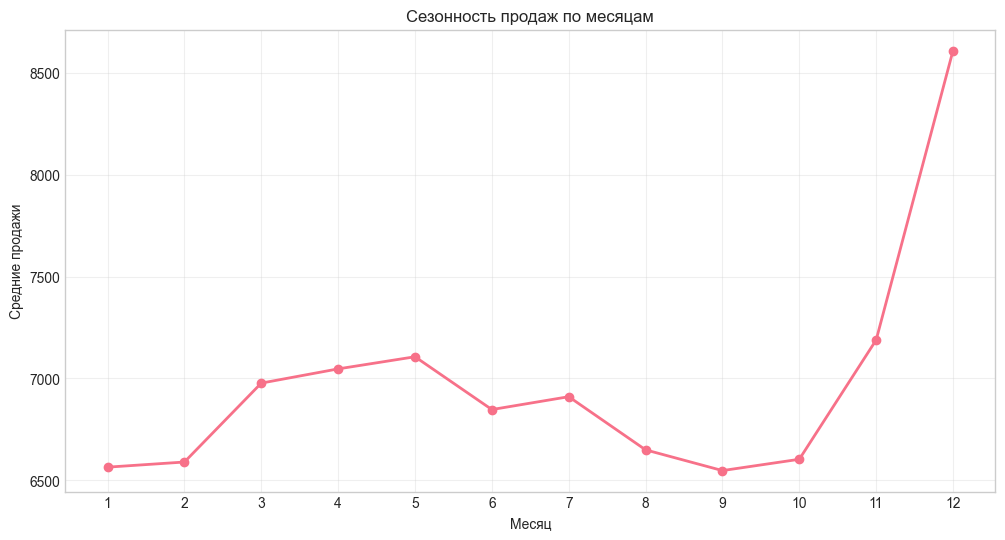

In [5]:
# 4. Сезонность по месяцам
print("\nСезонность продаж:")
df["Month"] = df["Date"].dt.month
monthly_sales = df.groupby("Month")["Sales"].mean()

plt.figure(figsize=(12, 6))
plt.plot(monthly_sales.index, monthly_sales.values, marker="o", linewidth=2)
plt.title("Сезонность продаж по месяцам")
plt.xlabel("Месяц")
plt.ylabel("Средние продажи")
plt.xticks(range(1, 13))
plt.grid(True, alpha=0.3)
plt.savefig(REPORTS_PATH / "seasonality.png", dpi=300, bbox_inches="tight")
plt.show()

In [6]:
# 5. Анализ выбросов
print("\nАнализ выбросов в продажах:")
Q1 = df["Sales"].quantile(0.25)
Q3 = df["Sales"].quantile(0.75)
IQR = Q3 - Q1
outliers = df[(df["Sales"] < Q1 - 1.5*IQR) | (df["Sales"] > Q3 + 1.5*IQR)]
print(f"Выбросов (>1.5*IQR): {len(outliers)} ({len(outliers)/len(df)*100:.2f}%)")


Анализ выбросов в продажах:
Выбросов (>1.5*IQR): 28701 (3.65%)



Корреляционный анализ:


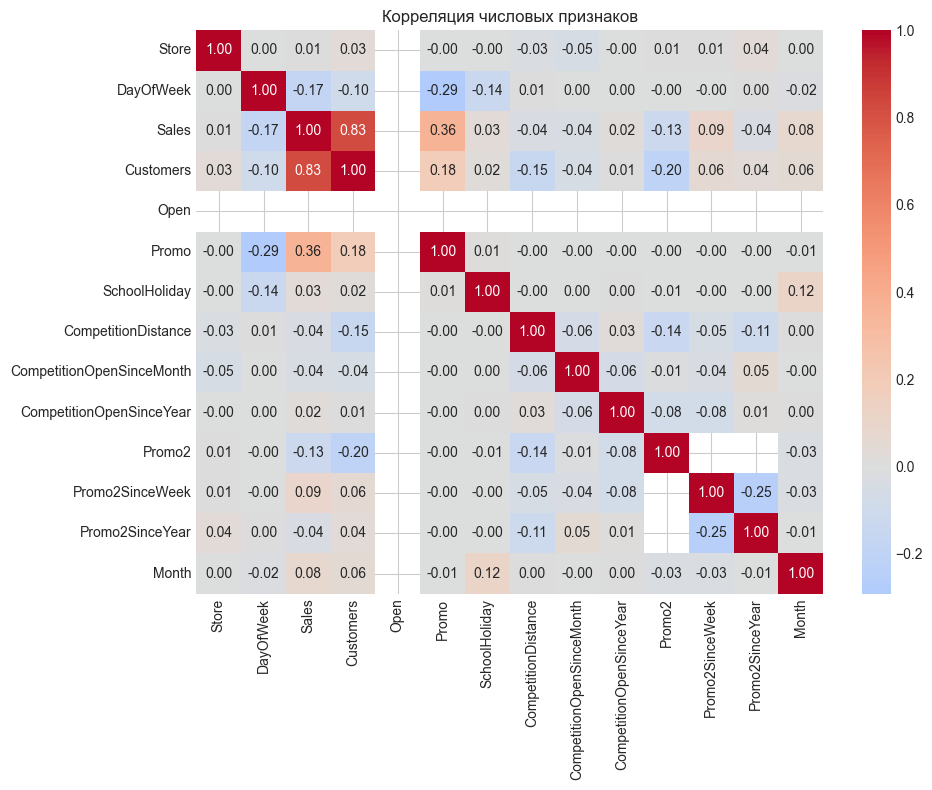


Корреляция с Sales:
Customers: +0.826
Promo: +0.364
Promo2: -0.128
DayOfWeek: -0.175


In [7]:
# 6. Корреляция числовых признаков
print("\nКорреляционный анализ:")
numeric_cols = df.select_dtypes(include=[np.number]).columns

if len(numeric_cols) > 1:
    corr_matrix = df[numeric_cols].corr()

    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", center=0)
    plt.title("Корреляция числовых признаков")
    plt.tight_layout()
    plt.savefig(REPORTS_PATH / "correlation_heatmap.png", dpi=300, bbox_inches="tight")
    plt.show()

    # Корреляция с Sales
    if "Sales" in corr_matrix.columns:
        sales_corr = corr_matrix["Sales"].sort_values(ascending=False)
        print("\nКорреляция с Sales:")
        for feature, corr in sales_corr.items():
            if feature != "Sales" and abs(corr) > 0.1:
                print(f"{feature}: {corr:+.3f}")

In [8]:
# 7. Анализ магазинов
print("\nАнализ по магазинам:")
store_stats = df.groupby("Store")["Sales"].agg(["mean", "std", "count"]).sort_values("mean", ascending=False)
print(f"Лучший магазин: {store_stats.index[0]} (средние продажи: {store_stats.iloc[0]["mean"]:.0f})")
print(f"Худший магазин: {store_stats.index[-1]} (средние продажи: {store_stats.iloc[-1]["mean"]:.0f})")


Анализ по магазинам:
Лучший магазин: 817 (средние продажи: 21784)
Худший магазин: 307 (средние продажи: 2704)


In [9]:
# 8. Выводы
print("КЛЮЧЕВЫЕ НАБЛЮДЕНИЯ:")
print("-"*50)
print(f"1. Лучшие дни для продаж: {sales_by_day["mean"].idxmax()} день недели")
print(f"2. Промо увеличивает продажи на: {promo_effect.loc[1, "diff_percent"]:.1f}%")
print(f"3. Лучший месяц: {monthly_sales.idxmax()} ({monthly_sales.max():.0f} средние продажи)")
print(f"4. Выбросы: {len(outliers)} записей требуют проверки")
print(f"5. Разброс между магазинами: в {store_stats.iloc[0]["mean"]/store_stats.iloc[-1]["mean"]:.1f} раза")

КЛЮЧЕВЫЕ НАБЛЮДЕНИЯ:
--------------------------------------------------
1. Лучшие дни для продаж: 7 день недели
2. Промо увеличивает продажи на: 38.3%
3. Лучший месяц: 12 (8609 средние продажи)
4. Выбросы: 28701 записей требуют проверки
5. Разброс между магазинами: в 8.1 раза
